In [ ]:
# !pip install ray[tune]
# !pip install grpcio
# !pip install grpcio-tools
# !pip install timm

In [50]:
# !python3 -c "import lightning" || pip install lightning==2.2.4
# !python3 -c "import torchsummary" || pip install torchsummary

In [1]:
import os
import torch
import tempfile
import timm
import numpy as np
import itertools
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from torchvision.transforms.v2 import functional as TVF
import torch.nn.functional as F
import lightning as L
from torch import nn
from torch.utils.data import Dataset
from filelock import FileLock
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision import models
from torchvision.transforms import v2
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Tuner
from ray.train import RunConfig, CheckpointConfig
from ray.train.lightning import (
    RayDDPStrategy,
    RayFSDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)
from sklearn.model_selection import train_test_split
import random
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from glob import glob

In [2]:
print(torch.cuda.get_arch_list())

['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects"

In [5]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._class_to_indices = {c: [] for c in self.known_classes}

        total_samples = 0
        for c in tqdm(self.known_classes):
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c, img))
                self._class_to_indices[c].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, anchor = self._all_samples[idx]
        
        positive_idx = random.choice(self._class_to_indices[label])
        positive = self._all_samples[positive_idx][1]
        
        neg_classes = [c for c in self.known_classes if c != label]
        negative_class = random.choice(neg_classes)
        negative_idx = random.choice(self._class_to_indices[negative_class])
        negative_label, negative = self._all_samples[negative_idx]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        anchor = torch.as_tensor(anchor) if not isinstance(anchor, torch.Tensor) else anchor
        positive = torch.as_tensor(positive) if not isinstance(positive, torch.Tensor) else positive
        negative = torch.as_tensor(negative) if not isinstance(negative, torch.Tensor) else negative

        return anchor, positive, negative, label, negative_label

known_classes = os.listdir(OBJECTS_ROOT)

print(f"All known classes: {known_classes}")
train_classes, test_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, val_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Quercus', 'Tilia', 'Corylus', 'Acer', 'Populus tremula', 'Betula', 'Alnus', 'Pinus', 'Salix']
Train classes: ['Acer', 'Salix', 'Populus tremula', 'Corylus', 'Alnus']
Validation classes: ['Betula', 'Quercus']
Test classes: ['Pinus', 'Tilia']

Load Train Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 913

Load Validation Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

Total samples: 296

Load Test Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 181


In [6]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            # print(img.unique())
            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [7]:
training_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 16,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

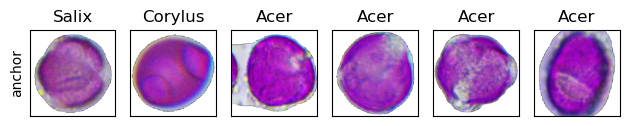

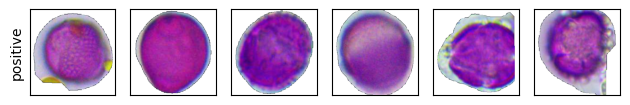

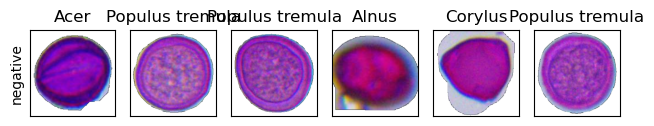

In [8]:
for anchor, positive, negative, label, negative_label in training_loader:
    plot(anchor[:6], row_title=["anchor"], labels=label[:6])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"], labels=negative_label[:6])
    break

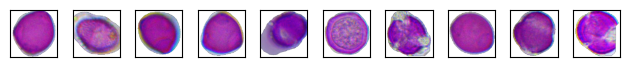

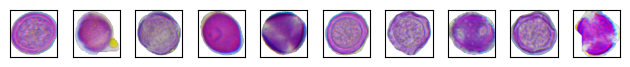

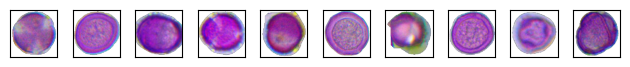

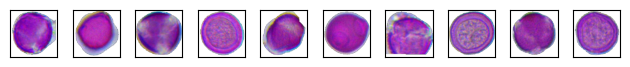

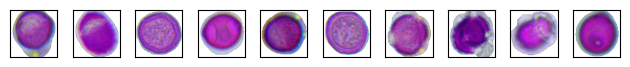

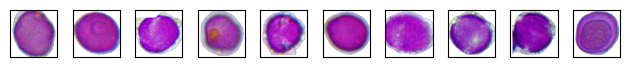

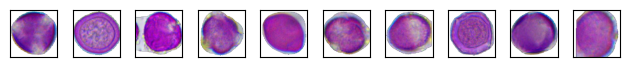

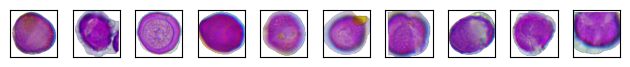

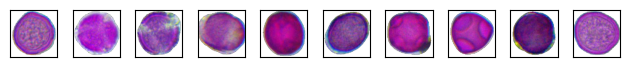

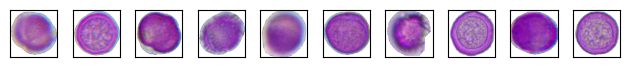

In [9]:
row_count = 0
for anchor, positive, negative, label, negative_label in training_loader:
    plot(anchor[:10])
    row_count +=1
    if row_count >= 10:
        break

In [19]:
class EmbeddingModel(nn.Module):
    def __init__(self, backbone, embeddings):
        super().__init__()
        if backbone == "resnet18":
            self.model = models.resnet18(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet34":
            self.model = models.resnet34(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet50":
            self.model = models.resnet50(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet101":
            self.model = models.resnet101(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet152":
            self.model = models.resnet152(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "efficientnet_v2":
            self.model = models.efficientnet_v2_s(weights='DEFAULT')
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Identity()
        elif backbone == "inception_v3":
            self.model = models.inception_v3(weights='DEFAULT', aux_logits=False)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "vit":
            self.model = models.vit_b_16(weights='DEFAULT')
            num_features = self.model.heads.head.in_features
            self.model.heads.head = nn.Identity()
        elif backbone == "swin_transformer":
            self.model = models.swin_t(weights='DEFAULT')
            num_features = self.model.head.in_features
            self.model.head = nn.Identity()
        else:
            raise ValueError("Unsupported backbone")

        self.embeddings = nn.Linear(num_features, embeddings)

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x

class PollenEmbedingsModule(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.optim_lr=config["optim_lr"]
        self.model = EmbeddingModel(config["backbone"], config["embedings_size"])
        
        config["check_val"]=5
        config["optim_betas"]=(0.9, 0.999)
        config["optim_eps"]=1e-08
        config["optim_weight_decay"]=0
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters(config)

        self.loss_function = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
        self.best_score = 0
        self.best_val_epoch = -1

        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.to(self.device)

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        anchor, positive, negative, label, _ = batch

        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        pred = {"train_loss": loss, "train_number": len(anchor_out)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss, sync_dist=True)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        anchor, positive, negative, label, _ = batch

        anchor_out = self.model(anchor)
        positive_out = self.model(positive)
        negative_out = self.model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)

        pred = {"val_loss": loss, "val_number": len(anchor_out)}
        self.validation_step_outputs.append(pred)
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.val_losses.append(mean_val_loss.item())

        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss, sync_dist=True)
        self.validation_step_outputs.clear()  # free memory

        if mean_val_loss > self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

        return {"log": tensorboard_logs}

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses))], self.val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [20]:
default_config = {
    "backbone": "resnet50",
    "optim_lr": 0.001,
    "embedings_size": 128,
}

In [46]:
# The maximum training epochs
num_epochs = 2

# Number of sampls from parameter space
num_samples = 2

# The directory for saving checkpoints
checkpoint_dir = os.path.join(os.getcwd(), "ray_results")

In [47]:
def train_func(config):
    model = PollenEmbedingsModule(config)

    trainer = pl.Trainer(
        devices="auto",
        accelerator="cpu",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
        max_epochs=num_epochs,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, train_dataloaders=training_loader, val_dataloaders=val_loader,)

In [48]:
scheduler = ASHAScheduler(
    max_t=num_epochs,
    grace_period=1, 
    eduction_factor=2)

In [49]:
search_space = {
    "backbone": tune.choice(["resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "efficientnet_v2", "inception_v3", "vit", "swin_transformer"]),
    "optim_lr": tune.loguniform(1e-5, 1e-2),
    "embedings_size": tune.choice([64, 128, 256]),
}

In [50]:
from ray.train import ScalingConfig

scaling_config = ScalingConfig(
    num_workers=1, use_gpu=False, resources_per_worker={"CPU": 2, "GPU": 0}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_loss",
        checkpoint_score_order="min",
    ),
    storage_path=checkpoint_dir,
    name="pollen_tuning",
)

In [51]:
from ray.train.torch import TorchTrainer

# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [52]:
def tune_pollen_asha(num_samples=10):    
    scheduler = ASHAScheduler(
        max_t=num_epochs, 
        grace_period=1, 
        reduction_factor=2
    )
    
    tuner = Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()

results = tune_pollen_asha(num_samples=num_samples)

2024-06-24 17:04:28,713	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-06-24 17:04:28,718	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-06-24 17:20:34,992	ERROR tune_controller.py:1331 -- Trial task failed for trial TorchTrainer_d149f_00000
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/s

In [ ]:
results.get_best_result(metric="val_loss", mode="min")